# Investigate the temporal effects of the law using the SVM

In [1]:
from echr import *
from nb_tfidf import *
from bert import *
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from csv import DictWriter
from tqdm import tqdm
from joblib import Parallel, delayed

%load_ext autoreload
%autoreload 2

In [ ]:
med_path = 'datasets/Medvedeva/'
json_path = 'datasets/echrod/cases.json'
part = 'facts'
article = '6'
balance = True
year = 2018
method = 'only'
best_alpha = 5

# df_complete = create_dataset(med_path, article, part)
df_complete = create_dataset(json_path, article, part)

In [10]:
def run_experiment(df_complete, year, method, window=None, train_size=None):
    
    # Prepare the data
    df_train, df_test = split_db(df_complete, method, year, window=window, train_size=train_size)
    df_train = balance_dataset(df_train) 
    X_train = df_train['text'].to_numpy()
    y_train = df_train['violation'].to_numpy()
    X_test = df_test['text'].to_numpy()
    y_test = df_test['violation'].to_numpy()
    
    # print(year, len(df_train), train_size)
    
    if len(y_test) > 0 and len(y_train) > 0:
        # Preprocess text
        X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
        X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])

        # Calculate TF-IDF
        tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                                 binary=True,
                                 smooth_idf=False)
        X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
        X_test_tfidf = tf_idf.transform(X_test_preprocessed)

        # Train model
        nb_model = SGDClassifier(n_jobs=1, alpha=0.0001, max_iter=100, penalty='l2')
        nb_model.fit(X_train_tfidf, y_train)

        # Test model
        preds = nb_model.predict(X_test_tfidf)
        acc, mcc, f1 = return_metrics(preds, y_test)
    else:
        acc, mcc, f1 = 0, 0, 0
    
    # Write the results to a csv file
    field_names = ['year', 'accuracy', 'MCC', 'F1',  'window', 'method', 
                   'training_size', 'test_size', 'train_distribution', 'test_distribution']
    dct = {
        'year': year,
        'accuracy': acc,
        'MCC': mcc,
        'F1': f1,
        'method': method,
        'window': window,
        'training_size': len(df_train),
        'test_size': len(df_test),
        'train_distribution': round(df_train['violation'].mean()*100,2),
        'test_distribution': round(df_test['violation'].mean()*100,2)
         }
    
    filename = 'results/SVM/years/years_'+method+'.csv'
    file_exists = os.path.isfile(filename)
    with open(filename, 'a') as f_object:
        dictwriter_object = DictWriter(f_object, fieldnames=field_names)
        if not file_exists:
            dictwriter_object.writeheader()  # file doesn't exist yet, write a header
        dictwriter_object.writerow(dct)
        f_object.close()
    return 0

In [11]:
# Test set includes all cases during 'year'
all_results = Parallel(n_jobs=-1)(delayed(run_experiment)(df_complete, year, method='only') for year in tqdm(range(1978, 2023)))

In [12]:
# Test set includes all cases during 'year' and train on random samples of a given size
results = pd.read_csv('results/SVM/years/years_only.csv')
train_sizes = dict(zip(results['year'], results['training_size']))
all_results = Parallel(n_jobs=8)(delayed(run_experiment)(df_complete, year, method='random', train_size=train_sizes[year]) for year in tqdm(range(1978, 2023)))

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:16<00:00,  2.71it/s]


In [10]:
# # Using sliding window of X past years
all_results = Parallel(n_jobs=4)(delayed(run_experiment)(df_complete, year, method='window', window=window) 
                                  for window in range(5, 60, 5) 
                                  for year in tqdm(range(1978, 2023)))

#### Analyze results

In [30]:
only_results = pd.read_csv('results/SVM/years/years_only.csv')
random_results = pd.read_csv('results/SVM/years/years_random.csv')
window_results = pd.read_csv('results/SVM/years/years_window.csv')

In [31]:
# Drop all cases before 1978 because most contain too little data
only_results = only_results[only_results['year'] >= 1978]
random_results = random_results[random_results['year'] >= 1978]
window_results = window_results[window_results['year'] >= 1978]

In [32]:
random_results.head()

,year,accuracy,MCC,F1,window,method,training_size,test_size,train_distribution,test_distribution
0,1978,0.333333,0.0,0.0,10,random,4,3,50.0,66.67
1,1979,0.000000,0.0,0.0,10,random,8,2,50.0,100.00
2,1980,0.333333,0.0,0.0,10,random,12,3,50.0,66.67
3,1981,0.500000,0.0,0.0,10,random,16,2,50.0,50.00
4,1982,0.166667,0.0,0.0,10,random,18,6,50.0,83.33


In [33]:
only_results.head()

,year,accuracy,MCC,F1,window,method,training_size,test_size,train_distribution,test_distribution
0,1978,0.333333,0.0,0.000000,10,only,4,3,50.0,66.67
1,1979,1.000000,0.0,1.000000,10,only,8,2,50.0,100.00
2,1980,0.666667,0.0,0.800000,10,only,12,3,50.0,66.67
3,1981,0.500000,0.0,0.666667,10,only,16,2,50.0,50.00
4,1982,0.833333,0.0,0.909091,10,only,18,6,50.0,83.33


In [25]:
only_results.groupby('year').mean()

,accuracy,MCC,F1,window,training_size,test_size,train_distribution,test_distribution
year,,,,,,,,
1978,0.333333,0.000000,0.000000,10.0,4.0,3.0,50.0,66.67
1979,1.000000,0.000000,1.000000,10.0,8.0,2.0,50.0,100.00
1980,0.666667,0.000000,0.800000,10.0,12.0,3.0,50.0,66.67
1981,0.500000,0.000000,0.666667,10.0,16.0,2.0,50.0,50.00
1982,0.833333,0.000000,0.909091,10.0,18.0,6.0,50.0,83.33
1983,0.714286,0.000000,0.833333,10.0,26.0,7.0,50.0,71.43
1984,0.800000,0.000000,0.888889,10.0,30.0,10.0,50.0,80.00
1985,0.750000,0.000000,0.857143,10.0,34.0,4.0,50.0,75.00
1986,0.571429,0.000000,0.727273,10.0,36.0,7.0,50.0,57.14


In [28]:
def plot_bar(data, title):
    plt.bar(data['year'], data['accuracy'])
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.1)

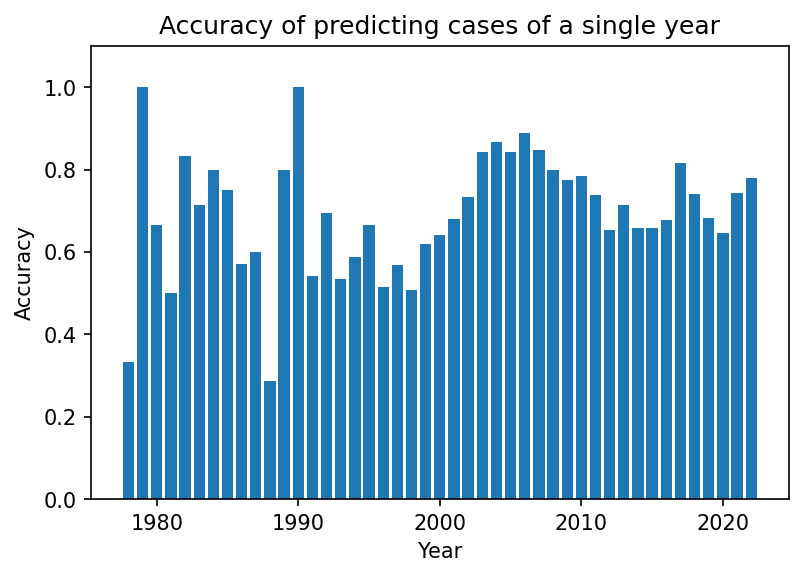

In [29]:
plot_bar(only_results, 'Accuracy of predicting cases of a single year')

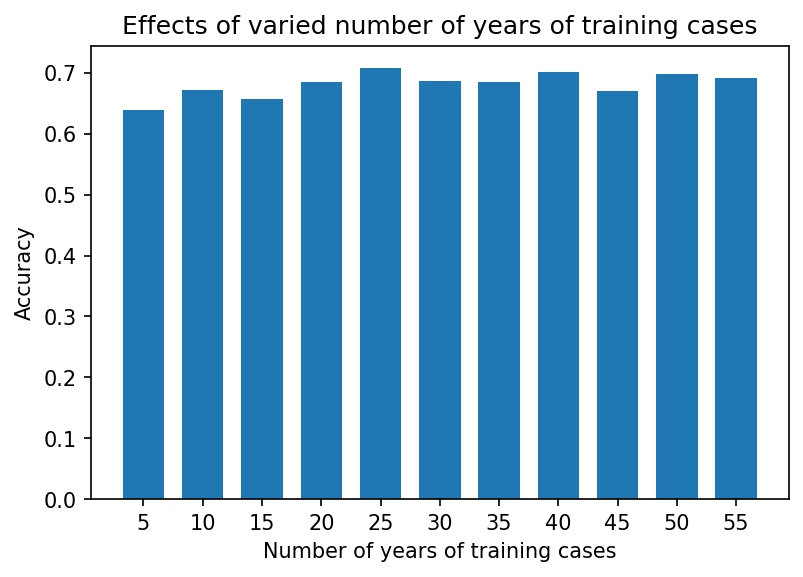

,year,accuracy,MCC,F1,training_size,test_size,train_distribution,test_distribution
window,,,,,,,,
5,2000.000000,0.638722,0.181006,0.718344,210.044444,183.577778,50.0,77.729778
10,2000.000000,0.672406,0.178734,0.761223,370.622222,183.577778,50.0,77.729778
15,2000.000000,0.657818,0.148282,0.738938,479.022222,183.577778,50.0,77.729778
20,2000.000000,0.685593,0.167704,0.780872,544.488889,183.577778,50.0,77.729778
25,1997.000000,0.708636,0.152829,0.807766,423.706667,146.586667,50.0,75.666800
30,1997.461538,0.687039,0.170015,0.765462,518.807692,159.384615,50.0,77.133462
35,2000.000000,0.684565,0.181299,0.770724,604.666667,183.577778,50.0,77.729778
40,2000.000000,0.701153,0.198918,0.780018,608.400000,183.577778,50.0,77.729778
45,2000.000000,0.670628,0.144692,0.759213,610.711111,183.577778,50.0,77.729778


In [31]:
grouped = window_results.groupby('window').mean()
plt.bar(grouped.index, grouped['accuracy'], width=3.5)
plt.title('Effects of varied number of years of training cases')
plt.xlabel('Number of years of training cases')
plt.ylabel('Accuracy')
plt.xticks(grouped.index)
plt.show()
grouped

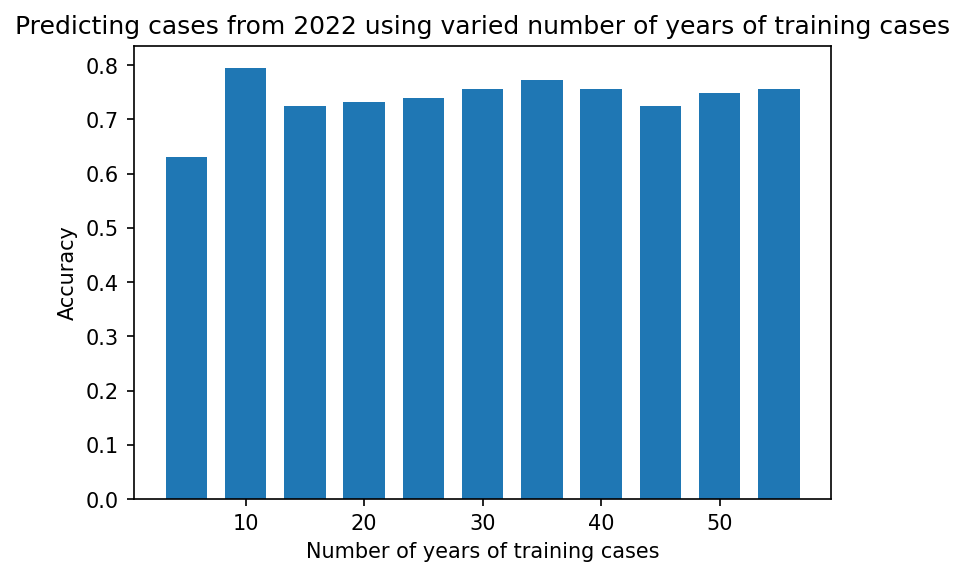

,year,accuracy,MCC,F1,window,method,training_size,test_size,train_distribution,test_distribution
57,2022,0.629921,0.310968,0.751323,5,window,432,127,50.0,92.91
112,2022,0.795276,0.396137,0.877358,10,window,852,127,50.0,92.91
162,2022,0.724409,0.327661,0.827586,15,window,1342,127,50.0,92.91
208,2022,0.732283,0.385999,0.831683,20,window,1622,127,50.0,92.91
282,2022,0.740157,0.392885,0.837438,25,window,1838,127,50.0,92.91
327,2022,0.755906,0.407296,0.848780,30,window,1956,127,50.0,92.91
374,2022,0.771654,0.422653,0.859903,35,window,2006,127,50.0,92.91
418,2022,0.755906,0.407296,0.848780,40,window,2024,127,50.0,92.91
464,2022,0.724409,0.379309,0.825871,45,window,2030,127,50.0,92.91
507,2022,0.748031,0.399979,0.843137,50,window,2040,127,50.0,92.91


In [32]:
grouped = window_results[window_results['year']==2022]#.groupby('window').mean()
plt.bar(grouped['window'], grouped['accuracy'], width=3.5)
plt.title('Predicting cases from 2022 using varied number of years of training cases')
plt.xlabel('Number of years of training cases')
plt.ylabel('Accuracy')
plt.show()
grouped